In [4]:
%load_ext autoreload
%autoreload 2

import os
import xarray as xr
import dask
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from aurora_benchmark.utils import xr_to_netcdf, update_running_statistics, reduce_statistics

dask.config.set(scheduler='threads')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Function arguments
toy = True
print(f"TOY: {toy}")

if toy:
    era5_surface_paths = [
        "../toy_data/era5-1d-360x180/msl-2021-2022-1d-360x180.nc",
        "../toy_data/era5-1d-360x180/t2m-2021-2022-1d-360x180.nc",
        "../toy_data/era5-1d-360x180/u10-2021-2022-1d-360x180.nc",
        "../toy_data/era5-1d-360x180/v10-2021-2022-1d-360x180.nc",
    ]
    era5_atmospheric_paths = [ 
        "../toy_data/era5-1d-360x180/t-2021-2022-1d-360x180.nc",
        "../toy_data/era5-1d-360x180/q-2021-2022-1d-360x180.nc",
        "../toy_data/era5-1d-360x180/u-2021-2022-1d-360x180.nc",
        "../toy_data/era5-1d-360x180/v-2021-2022-1d-360x180.nc",
        "../toy_data/era5-1d-360x180/z-2021-2022-1d-360x180.nc",
    ]
    era5_static_paths = [
        "/projects/prjs0981/ewalt/aurora_benchmark/data/era5_wb2/2021-2022-6h-1440x721/lsm_static-1440x721.nc",
        "/projects/prjs0981/ewalt/aurora_benchmark/data/era5_wb2/2021-2022-6h-1440x721/z_static-1440x721.nc",
        "/projects/prjs0981/ewalt/aurora_benchmark/data/era5_wb2/2021-2022-6h-1440x721/slt_static-1440x721.nc",
    ]

    # Load the data into a single dataset with the same coords but multiple variables
    surface_dss = [
        xr.open_dataset(path, engine="netcdf4").drop_vars("time_bnds")
        #xr.open_dataset(path, engine="h5netcdf").rename({"msl": svar}).drop_vars("time_bnds")
        #xr.open_zarr(path, chunks={"time": 50, "latitude": 180, "longitude": 360}).rename({"msl": svar})#.drop_vars("time_bnds")
        for path in era5_surface_paths
    ]
    surface_ds = xr.merge(surface_dss).rename({"t2m": "2t", "u10": "10u", "v10": "10v", "lat": "latitude", "lon": "longitude"})
    atmospheric_dss = [
        xr.open_dataset(path, engine="netcdf4").drop_vars("time_bnds")
        #xr.open_dataset(path, engine="h5netcdf").rename({"msl": svar}).expand_dims({"level": [1000, 700, 250]}).drop_vars("time_bnds")
        #xr.open_zarr(path, chunks={"time": 50, "latitude": 180, "longitude": 360, "level": 1}).rename({"msl": svar}).expand_dims({"level": [1000, 700, 250]})#.drop_vars("time_bnds")
        for path in era5_atmospheric_paths
    ]
    atmospheric_ds = xr.merge(atmospheric_dss).rename({"lat": "latitude", "lon": "longitude"})
    static_dss = [
        xr.open_dataset(path, engine="netcdf4").coarsen(longitude=1440//360, latitude=721//180, boundary="trim").mean()
        # xr.open_dataset(path, engine="h5netcdf").rename({"msl": svar}).isel(time=0).drop_vars("time_bnds")
        #xr.open_zarr(path, chunks={"latitude": 180, "longitude": 360}).rename({"msl": svar}).isel(time=0)#.drop_vars("time_bnds")
        for path in era5_static_paths
    ]
    static_ds = xr.merge(static_dss)
    
    forecast_dir = "/projects/prjs0981/ewalt/aurora_benchmark/data/era5_wb2_forecasts/2021-2022-1d-1w-10w-360x180_original_variables/"
    eval_dir = "data/era5_wb2_eval/2021-2022-1d-1w-10w-360x180_original_variables/"
   
else: 
    era5_surface_paths = [
    "/projects/prjs0981/ewalt/aurora_benchmark/data/era5_wb2/2021-2022-6h-1440x721/10v_2021-2022-6h-1440x721.nc",
    "/projects/prjs0981/ewalt/aurora_benchmark/data/era5_wb2/2021-2022-6h-1440x721/2t_2021-2022-6h-1440x721.nc",
    #  - data/era5_wb2/2021-2022-6h-1440x721/tp_2021-2022-6h-1440x721.nc # original only
    "/projects/prjs0981/ewalt/aurora_benchmark/data/era5_wb2/2021-2022-6h-1440x721/10u_2021-2022-6h-1440x721.nc",
    "/projects/prjs0981/ewalt/aurora_benchmark/data/era5_wb2/2021-2022-6h-1440x721/msl_2021-2022-6h-1440x721.nc",
    #  - data/era5_wb2/2021-2022-6h-1440x721/sst_2021-2022-6h-1440x721.nc # original only
    ]
    era5_atmospheric_paths = [
    "/projects/prjs0981/ewalt/aurora_benchmark/data/era5_wb2/2021-2022-6h-1440x721/q_2021-2022-6h-1440x721.nc",
    "/projects/prjs0981/ewalt/aurora_benchmark/data/era5_wb2/2021-2022-6h-1440x721/t_2021-2022-6h-1440x721.nc",
    "/projects/prjs0981/ewalt/aurora_benchmark/data/era5_wb2/2021-2022-6h-1440x721/u_2021-2022-6h-1440x721.nc",
    "/projects/prjs0981/ewalt/aurora_benchmark/data/era5_wb2/2021-2022-6h-1440x721/v_2021-2022-6h-1440x721.nc",
    "/projects/prjs0981/ewalt/aurora_benchmark/data/era5_wb2/2021-2022-6h-1440x721/z_2021-2022-6h-1440x721.nc",
    ]
    era5_static_paths = [
    "/projects/prjs0981/ewalt/aurora_benchmark/data/era5_wb2/2021-2022-6h-1440x721/lsm_static-1440x721.nc",
    "/projects/prjs0981/ewalt/aurora_benchmark/data/era5_wb2/2021-2022-6h-1440x721/z_static-1440x721.nc",
    "/projects/prjs0981/ewalt/aurora_benchmark/data/era5_wb2/2021-2022-6h-1440x721/slt_static-1440x721.nc",
    ]

    forecast_dir = "/projects/prjs0981/ewalt/aurora_benchmark/data/era5_wb2_forecasts/2021-2022-6h-1d-6w-1440x721_original_variables/"
    eval_dir = "data/era5_wb2_eval/2021-2022-6h-1d-6w-1440x721_original_variables"
    
    # Load the data into a single dataset with the same coords but multiple variables
    surface_ds = xr.merge([
        xr.open_dataset(p, engine="netcdf4", chunks={"time": 50, "latitude": 721, "longitude": 1440})
        for p in era5_surface_paths
    ])

    atmospheric_ds = xr.merge([
        xr.open_dataset(p, engine="netcdf4", chunks={"time": 50, "latitude": 721, "longitude": 1440, "level": 1})
        for p in era5_atmospheric_paths
    ])

    static_ds = xr.merge([
        xr.open_dataset(p, engine="netcdf4", chunks={"latitude": 721, "longitude": 1440})
        for p in era5_static_paths
    ])
    
surf_vars = ["2t", "msl", "10u", "10v"]
atmospheric_vars = ["t", "z", "u", "v"]

interest_levels = [1000, 700, 250]
interest_variables = surf_vars + atmospheric_vars

assert os.path.exists(forecast_dir), f"Forecast directory {forecast_dir} does not exist"
os.makedirs(eval_dir, exist_ok=True)

surface_ds.dims, atmospheric_ds.dims, static_ds.dims

TOY: True


(FrozenMappingWarningOnValuesAccess({'time': 365, 'longitude': 360, 'latitude': 180}),
 FrozenMappingWarningOnValuesAccess({'time': 365, 'longitude': 360, 'latitude': 180, 'level': 13}),
 FrozenMappingWarningOnValuesAccess({'latitude': 180, 'longitude': 360}))

In [8]:
import xarray as xr

class RunningStatistics(object):
    def __init__(self):
        self._means = {}
        self.means_of_squared = {}
        self.num_samples = {}

    def update(self, sample_ds: xr.Dataset):
        for var in sample_ds.data_vars:
            if var not in self.num_samples:
                print(f"New variable {var}")
                self.num_samples[var] = 0
                self._means[var] = sample_ds[var]
                self.means_of_squared[var] = sample_ds[var]**2
                print(f"means[var] shape:", self._means[var].shape)
                print(f"means_of_squared[var] shape:", self.means_of_squared[var].shape)
            else:
                print(f"Accumulating variable {var}")
                self._means[var] = (self._means[var] * self.num_samples[var] + sample_ds[var]) / (self.num_samples[var] + 1)
                self.means_of_squared[var] = (self.means_of_squared[var] * self.num_samples[var] + sample_ds[var]**2) / (self.num_samples[var] + 1)
                print(f"means[var] shape:", self._means[var].shape)
                print(f"means_of_squared[var] shape:", self.means_of_squared[var].shape)
            self.num_samples[var] += 1

    @property
    def stds(self):
        return xr.Dataset({var: (self.means_of_squared[var] - self._means[var]**2)**0.5 for var in self._means})
    
    @property
    def means(self):
        return xr.Dataset(self._means)
    
    def rmse(self, dim=["latitude", "longitude"], reduce="mean"):
        if reduce == "mean":
            return np.sqrt(((self.means**2).mean(dim=dim)))
        elif reduce == "std":
            return np.sqrt(((self.means**2).std(dim=dim)))
        else:
            raise ValueError(f"Unknown reduce method {reduce}")
    
    @property
    def variables(self):
        return list(self.num_samples.keys())

In [9]:
global_statistics = {
    "surface_vars": RunningStatistics(),
    "atmospheric_vars": RunningStatistics(),
}
med_dry_statistics = {
    "surface_vars": RunningStatistics(),
    "atmospheric_vars": RunningStatistics(),
}
med_wet_statistics = {
    "surface_vars": RunningStatistics(),
    "atmospheric_vars": RunningStatistics(),
}

# define wet (oct-mar) and dry (apr-sep) seasons
wet_months = [10, 11, 12, 1, 2, 3]
dry_months = [4, 5, 6, 7, 8, 9]

# define med
med_region = {    
    "latitude": slice(47, 29), # decreasing
    "longitude": slice(-8+180, 38+180) # in [0, 360)
}

best_preds = {
    var: var
}

# loop over files
for i, file in enumerate(os.scandir(forecast_dir)):
    # parse file info
    file_info = file.name.replace(".nc", "").split("_")
    variable_name = file_info[1]
    file_info = file_info[2].split("-")
    init_time = pd.Timestamp(file_info[0])
    base_frequency = file_info[1]
    eval_aggregation = file_info[2]
    eval_start = file_info[3]
    forecast_horizon = file_info[4]    

    # feedback
    print(f"Processing {file.name}")

    # load forecast
    pred_trajectory = xr.open_dataset(file.path, engine="netcdf4")
    assert pd.Timedelta((pred_trajectory.lead_time[1]-pred_trajectory.lead_time[0]).values) == pd.Timedelta(eval_aggregation)

    # load ERA5 gt from surface_ds and atmospheric_ds
    true_ds = atmospheric_ds if variable_name in atmospheric_ds.data_vars else surface_ds
    true_trajectory = true_ds[variable_name]\
            .sel(time=slice(init_time+pd.Timedelta(eval_start), init_time+pd.Timedelta(forecast_horizon)))

    # resample gt to eval_aggregation
    true_trajectory = true_trajectory.resample(time=pd.Timedelta(eval_aggregation), origin=init_time).mean()
    assert pd.Timedelta((true_trajectory.time[1]-true_trajectory.time[0]).values) == pd.Timedelta(eval_aggregation)
    
    # rename true time to lead time
    true_trajectory = true_trajectory.rename({"time": "lead_time"})
    true_trajectory["lead_time"] = true_trajectory["lead_time"] - np.datetime64(init_time)

    # shape
    sizes = pred_trajectory.sizes
    nlt = len(np.unique(pred_trajectory.lead_time.values))
    if variable_name in atmospheric_ds.data_vars:
        stat_key = "atmospheric_vars"
    else:
        stat_key = "surface_vars"
        
    # compute error
    signed_error_ds = (pred_trajectory - true_trajectory)
    global_statistics[stat_key].update(signed_error_ds)
    
    if init_time.month in wet_months:
        med_wet_statistics[stat_key].update(signed_error_ds.sel(med_region))
    elif init_time.month in dry_months:
        med_dry_statistics[stat_key].update(signed_error_ds.sel(med_region))
    
    if i == 50: break

Processing forecast_2t_20210206T090000-1d-1w-1w-10w-360x180.nc
New variable 2t
means[var] shape: (9, 180, 360)
means_of_squared[var] shape: (9, 180, 360)
New variable 2t
means[var] shape: (9, 18, 47)
means_of_squared[var] shape: (9, 18, 47)
Processing forecast_t_20210501T090000-1d-1w-1w-10w-360x180.nc
New variable t
means[var] shape: (9, 3, 180, 360)
means_of_squared[var] shape: (9, 3, 180, 360)
New variable t
means[var] shape: (9, 3, 18, 47)
means_of_squared[var] shape: (9, 3, 18, 47)
Processing forecast_10u_20210821T090000-1d-1w-1w-10w-360x180.nc
New variable 10u
means[var] shape: (9, 180, 360)
means_of_squared[var] shape: (9, 180, 360)
New variable 10u
means[var] shape: (9, 18, 47)
means_of_squared[var] shape: (9, 18, 47)
Processing forecast_t_20210717T090000-1d-1w-1w-10w-360x180.nc
Accumulating variable t
means[var] shape: (9, 3, 180, 360)
means_of_squared[var] shape: (9, 3, 180, 360)
Accumulating variable t
means[var] shape: (9, 3, 18, 47)
means_of_squared[var] shape: (9, 3, 18, 4

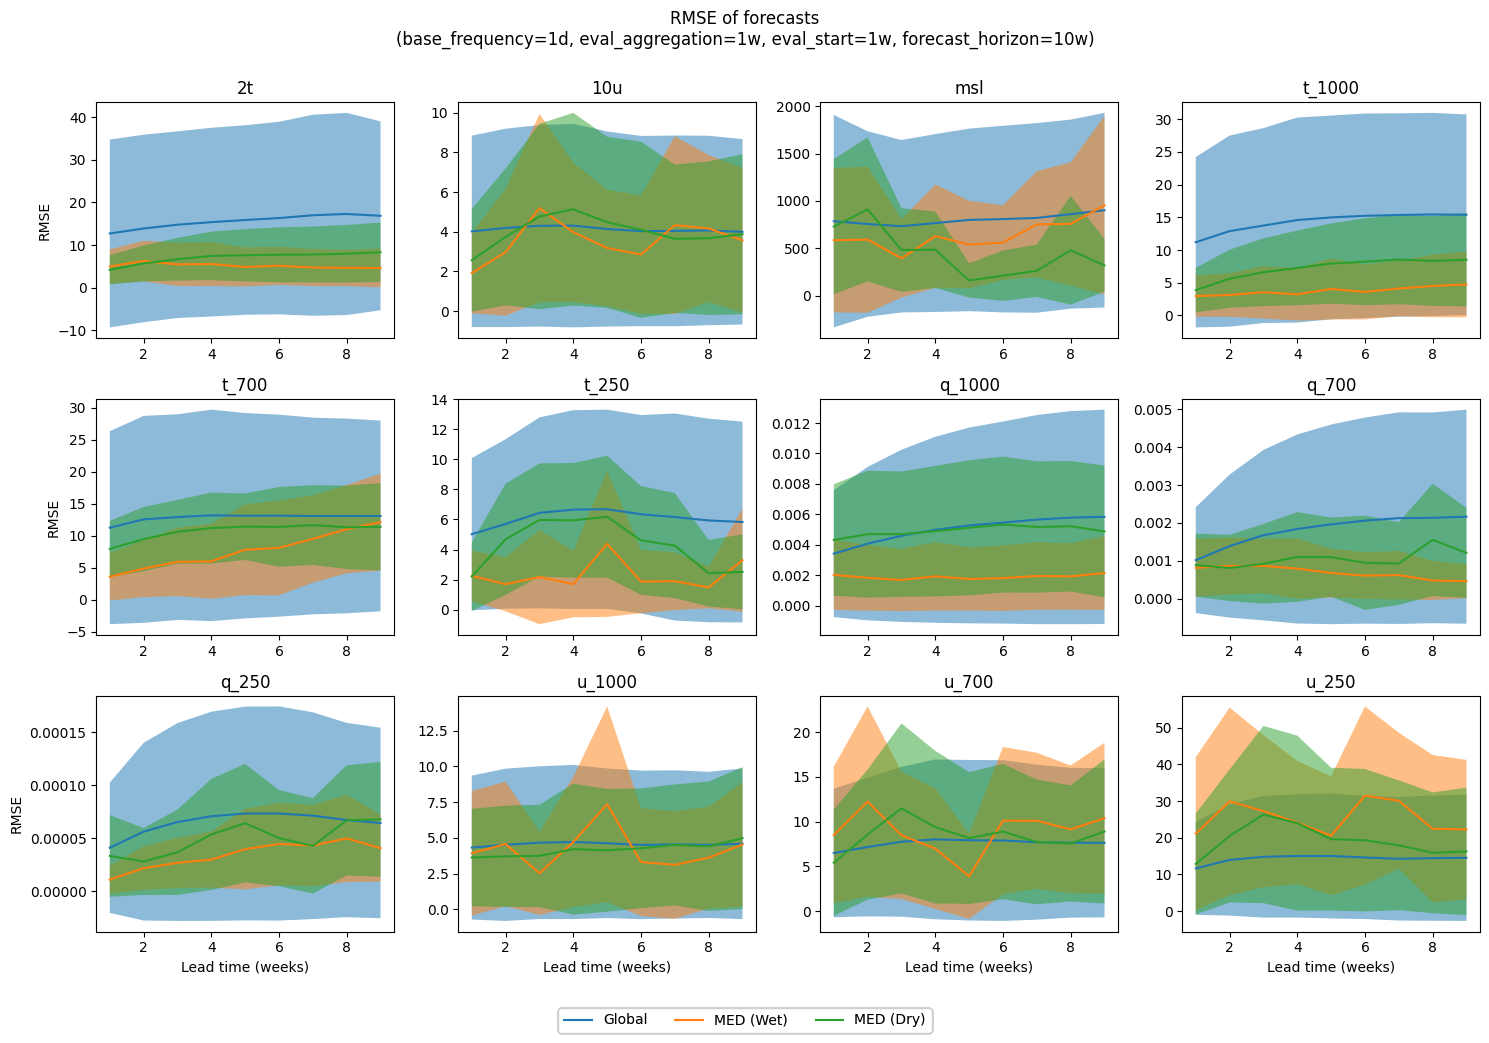

In [38]:
# plot maps

global_stats = global_statistics
med_dry_stats = med_dry_statistics
med_wet_stats = med_wet_statistics

nrows = 4

all_vars = global_statistics["surface_vars"].variables
for var in global_stats["atmospheric_vars"].variables:
    for level in global_stats["atmospheric_vars"]._means[var].level.values:
        all_vars.append(f"{var}_{int(level)}")
    
fig_curves, axes_curves = plt.subplots(
    ncols=len(all_vars)//nrows,
    nrows=nrows, 
    figsize=(15, 10)
)

for i, var in enumerate(all_vars):
    # get key
    variable_name = var
    if var in global_stats["surface_vars"].variables:
        stat_key = "surface_vars"
    else:
        stat_key = "atmospheric_vars"
        var, level = var.split("_")
        level = float(level)
    # compute rmse
    global_rmse = global_stats[stat_key].rmse(dim=["latitude", "longitude"])[var]
    global_rmse_std = global_stats[stat_key].rmse(dim=["latitude", "longitude"], reduce="std")[var]
    med_wet_rmse = med_wet_stats[stat_key].rmse(dim=["latitude", "longitude"])[var]
    med_wet_rmse_std = med_wet_stats[stat_key].rmse(dim=["latitude", "longitude"], reduce="std")[var]
    med_dry_rmse = med_dry_stats[stat_key].rmse(dim=["latitude", "longitude"])[var]
    med_dry_rmse_std = med_dry_stats[stat_key].rmse(dim=["latitude", "longitude"], reduce="std")[var]
    if stat_key == "atmospheric_vars":
        global_rmse = global_rmse.sel(level=level)
        global_rmse_std = global_rmse_std.sel(level=level)
        med_wet_rmse = med_wet_rmse.sel(level=level)
        med_wet_rmse_std = med_wet_rmse_std.sel(level=level)
        med_dry_rmse = med_dry_rmse.sel(level=level)
        med_dry_rmse_std = med_dry_rmse_std.sel(level=level)
    # plot all regions
    for rmse, rmse_std, label in zip(
        [global_rmse, med_wet_rmse, med_dry_rmse],
        [global_rmse_std, med_wet_rmse_std, med_dry_rmse_std],
        ["Global", "MED (Wet)", "MED (Dry)"]
    ):
        lead_times = [pd.Timedelta(lt)/pd.Timedelta("1w") for lt in rmse.lead_time.values]
        ax = axes_curves.flat[i]
        ax.plot(
            lead_times,
            rmse,
            label=label
        )
        ax.fill_between(
            lead_times,
            rmse - rmse_std,
            rmse + rmse_std,
            alpha=0.2
        )
        ax.set_title(f"{variable_name}")
        if i % (len(all_vars) // nrows) == 0:
            ax.set_ylabel("RMSE")
        if i >= len(all_vars) - (len(all_vars) // nrows):
            ax.set_xlabel("Lead time (weeks)")
        ax.grid(False)

    # Add legend at the bottom of the figure
    handles, labels = ax.get_legend_handles_labels()
    fig_curves.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))
    # Add title
    fig_curves.suptitle(f"RMSE of forecasts\n(base_frequency={base_frequency}, eval_aggregation={eval_aggregation}, eval_start={eval_start}, forecast_horizon={forecast_horizon})\n")
plt.tight_layout()
plt.show()
